# Results of the OptoSim super-resolution project

## Get data

In [117]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
import json
from sklearn.metrics import mean_squared_error


import optosim 

from optosim.settings import DATA_DIR, MODEL_DIR

from optosim.simulation.event_reader import EventReader, show_data

from optosim.super_resolution.model import SuperResolutionModel
from optosim.super_resolution.model import create_datasets

import optosim.super_resolution.model_utils as model_utils

from optosim.model_train import read_events, get_model_parameters

from optosim.super_resolution.model_utils import (
    reshape_data,
    weighted_average_estimator,
    downsample_heatmaps_to_dimensions,
    mse,
    r_squared,
)


from optosim.super_resolution.model import SuperResolutionModel, create_datasets


In [118]:
show_data(DATA_DIR)

Found 9 subdirectories
Subdirectories:
['logs', 'mc0000', 'mc0001', 'mc0002', 'mc0003', 'mc0004', 'mc0005', 'mc0006', 'mc9999']


,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2
6,mc0006,XAMS,10000,"[1000, 25000]",False,True,3.2
7,mc9999,XAMS,100,10000,False,True,8.0


In [119]:
run_id = 'mc0006'
nmax = 1_000
pmts_per_dim = 3.2

# read data
run_id_dir = os.path.join(DATA_DIR, run_id)
files = glob.glob(run_id_dir + '/*.hd5f')

print(f"Reading data from {run_id_dir}")
print(f"Found {len(files)} files")

true_pos, fine_top, top = read_events(files, nmax=nmax)
    

Reading data from /data/xenon/acolijn/optosim/data/mc0006
Found 100 files
number of files:  100
Found 9 subdirectories
Subdirectories:
['logs', 'mc0000', 'mc0001', 'mc0002', 'mc0003', 'mc0004', 'mc0005', 'mc0006', 'mc9999']
processed  0 events
processed  1000 events
We have 1000 events
low res PMT has shape (2, 2)
high res truth has shape (20, 20)
true positions have shape (3,)


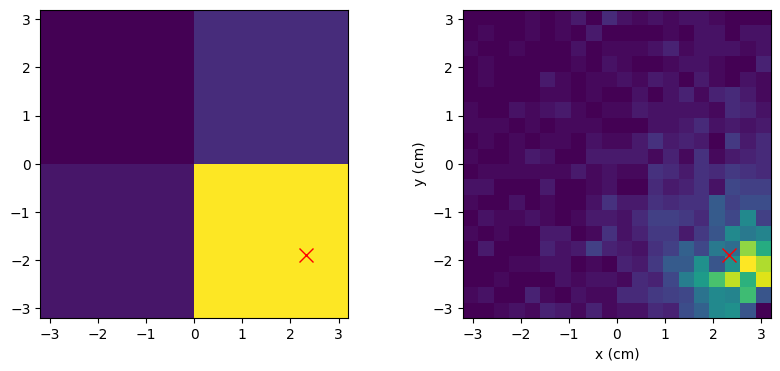

In [120]:
# check if data is ok
num = 4
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.ravel()
r = 3.2

ax[0].imshow(
    top[num], 
    interpolation="nearest", 
    origin="lower", 
    extent=[-r, r, -r, r]
)

ax[1].imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-r, r, -r, r],
)

for i in range(2):
    ax[i].plot(
        true_pos[num][0],
        true_pos[num][1],
        marker="x",
        markersize=10,
        color="red",
        label="true position",
    )

plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

In [121]:
pmts_per_dim = 5

In [122]:
# create train and test sets
y = np.asarray(fine_top)
X = np.asarray(top)
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(
    X, y, pos, train_fraction=0.8
)

y_test_downsampled = model_utils.downsample_heatmaps_to_dimensions(y_test,pmts_per_dim,pmts_per_dim)

In [123]:
   
wa_pred = weighted_average_estimator(X_test, r=2.5)
wa_mse = mse(pos_test, wa_pred)
wa_r2 = r_squared(pos_test, wa_pred)

In [124]:
!ls /data/xenon/cfuselli/software/OptoSim/_trash/models/

model1.pkl  model5.pkl		     scaling_model_2x2.pkl
model2.pkl  model6.pkl		     scaling_model_500kdata_20x20.pkl
model3.pkl  model_idiot.pkl	     scaling_model_5x5.pkl
model4.pkl  scaling_model_20x20.pkl


In [125]:
# load the trained models
base = '/data/xenon/cfuselli/software/OptoSim/_trash/models/'

with open(base+'model1.pkl', 'rb') as f:
    model1 = pickle.load(f) #20x20


ModuleNotFoundError: No module named 'Model'